In [13]:
"""
Imports

ETHNICITIES = { 0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Hispanic" }
GENDERS = { 0: "Male", 1: "Female" }
"""
# !pip install numpy
# !pip install torch
# !pip install torchvision
# !pip install pandas
# !pip install opencv-python
# !pip install matplotlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import csv
import cv2
from datetime import datetime
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataset import FacesDataset

In [14]:
"""Creating the Neural Network Class"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input: 48 x 48 x 1 = 2304
        ### Inputs to Conv2d: Incoming layers, outgoing layers, Frame size

        self.conv1 = nn.Conv2d(1, 2, 3)  #48 --> 46
        self.pool1 = nn.MaxPool2d(2, 2)  #46 --> 23
        self.conv2 = nn.Conv2d(2, 4, 3, stride=2)  #23 --> 11
        self.conv3 = nn.Conv2d(4, 8, 3, stride=2) #11 --> 5

        # Activation function to use
        self.activation = F.relu

        self.fc1 = nn.Linear(200, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 3)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool1(x)
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = x.view(-1, 200)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [36]:
"""Setting up neural network parameters, defining accuracy function"""
batch_size = 32
learning_rate = 0.005
num_epochs = 10

data_path = "age_gender.csv"

dataset = FacesDataset(csv_file=data_path)
num_data_items = dataset.__len__()

train_set, test_set = torch.utils.data.random_split(dataset, [int(num_data_items*0.8), int(num_data_items*0.2)])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
# model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



def check_accuracy(loader, model):
    """
    Checks accuracy of the model by running it on the data in the dataloader passed as a parameter
    
    The closer the returned score is to 0, the better
    """
    num_correct_age = 0
    num_correct_race = 0
    num_correct_gender = 0
    num_samples = loader.__len__()
    model.eval()
    
    with torch.no_grad():  #speeds up process
        for x, y in loader:
            x = x.to(device=device)   #shape: (32, 48, 48)
            y = y.to(device=device)   #shape: (32, 3)
            
            #GETTING AND FORMATTING MODEL PREDICTIONS
            x = x.unsqueeze(1)   #Add a dimension to the tensor for number of channels (which is 1)
            scores = model(x.float())   #Shape: (32, 3)
#             print("scores: " + str(scores))
            
            #GETTING NUM CORRECT
#             race = torch.round(scores[:,1].clone())    #Getting integer-rounded copy of races
#             gender = torch.round(scores[:,2].clone())  #Getting integer-rounded copy of gender
#             scores = torch.column_stack((torch.round(scores[:,0]), race))  #recreating 32x3 tensor with integer rounded age, race, and gender
#             scores = torch.column_stack((scores, gender))
#             print("scores: " + str(scores))
#             print("y: " + str(y))
            
            #CALCULATING ACCURACY SCORE
            age_diffs = torch.abs(scores[:,0] - y[:,0])
            race_diffs = torch.abs(scores[:,1] - y[:,1])
            gender_diffs = torch.abs(scores[:,2] - y[:,2])
            age_diff_avg = torch.mean(age_diffs)
            race_diff_avg = torch.mean(race_diffs)
            gender_diff_avg = torch.mean(gender_diffs)
            
            age_std = torch.std(age_diffs)
            race_std = torch.std(race_diffs)
            gender_std = torch.std(gender_diffs)
            
            age_accuracy = age_diff_avg/age_std
            race_accuracy = race_diff_avg/race_std
            gender_accuracy = gender_diff_avg/gender_std
            total_accuracy = (age_accuracy + race_accuracy + gender_accuracy) / 3

#             print("------------------------")
#             print("age_accuracy: " + str(age_accuracy))
#             print("race_accuracy: " + str(race_accuracy))
#             print("gender_accuracy: " + str(gender_accuracy))
#             print("total_accuracy: " + str(total_accuracy))
#             print("------------------------")
        
#         print(f'accuracy score (the closer to zero, the better): {total_accuracy}')
    return total_accuracy


def scale_scores(data):
    c0 = data[:,0]
    c1 = data[:,1]
    c2 = data[:,2]
    mean = torch.mean(c0)
    transformed0 = c0/mean
    mean = torch.mean(c1)
    transformed1 = c1/mean
    mean = torch.mean(c2)
    transformed2 = c2/mean
    transformed = torch.column_stack((transformed0, transformed1))
    transformed = torch.column_stack((transformed, transformed2))
#     print(transformed)
    return transformed

In [37]:
"""Training"""

all_losses = []
all_train_acc = []
all_test_acc = []
for epoch in range(num_epochs):  #Looping through epochs
    losses = []
    
    for batch_idx, (data, targets) in enumerate(train_loader):   #Looping through batches
        #Get data to cuda if possible
        data = data.to(device=device)             #data is a torch tensor of 32 48x48 images (shape=[32,48,48])
        data = data.unsqueeze(1)                  #Add a dimension to the tensor for number of channels (which is 1)
#         print("data.shape: " + str(data.shape))
        targets = targets.to(device=device)       #data is a torch tensor of 32 sets of 3 annotations (shape=[32,3])
#         print("tagrets.shape: " + str(targets.shape))
#         print("data[0,:,:].shape: " + str(np.array(data[0,:,:].shape)))
#         cv2.imwrite("test.png", np.array(data[0,:,:]))
        
        #Forward prop
        scores = model(data.float())
        
        #Scale scores and targets so all entries are between 0 and 1
        scores_scaled = scale_scores(scores)
        targets_scaled = scale_scores(targets)
        
#         print("scores: " + str(scores))
#         print("scores_scaled: " + str(scores_scaled))
#         print("targets: " + str(targets))
#         print("targets_scaled: " + str(targets_scaled))
        loss = criterion(scores_scaled, targets_scaled)
#         print(loss)
        
        losses.append(loss.item())
        
        #Backward prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  #gradient descent
    
    l = sum(losses)/len(losses)
    all_losses.append(l)
    train_acc = check_accuracy(train_loader, model)
    all_train_acc.append(train_acc)
    test_acc = check_accuracy(test_loader, model)
    all_test_acc.append(test_acc)
    print(f"Epoch: {epoch + 1}, Loss: {l}, Train Acc: {train_acc}, Test Acc: {test_acc}")


Epoch: 1, Loss: 0.7361786794702682, Train Acc: 132.30091857910156, Test Acc: 208.58447265625
Epoch: 2, Loss: 0.6430093073623779, Train Acc: 157.34471130371094, Test Acc: 152.08395385742188
Epoch: 3, Loss: 0.6182443788542112, Train Acc: 213.51182556152344, Test Acc: 205.20269775390625
Epoch: 4, Loss: 0.6083486533989191, Train Acc: 154.328857421875, Test Acc: 312.5765686035156
Epoch: 5, Loss: 0.5820909787289811, Train Acc: 154.19679260253906, Test Acc: 188.3456268310547
Epoch: 6, Loss: 0.5767212998103131, Train Acc: 189.1984405517578, Test Acc: 225.1914520263672
Epoch: 7, Loss: 0.5669590545092626, Train Acc: 185.26722717285156, Test Acc: 224.02627563476562
Epoch: 8, Loss: 0.5560002037485776, Train Acc: 166.9034881591797, Test Acc: 190.71401977539062
Epoch: 9, Loss: 0.5488405347775046, Train Acc: 138.7461700439453, Test Acc: 210.38368225097656
Epoch: 10, Loss: 0.5412753394994929, Train Acc: 151.29226684570312, Test Acc: 181.66607666015625


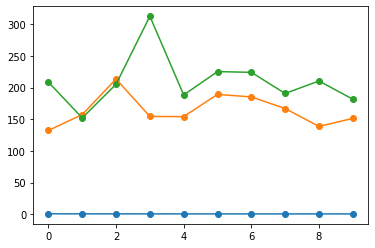

In [41]:
"""Plotting Results"""

# print("Checking final accuracy on training data.")
# check_accuracy(train_loader, model)

# print("Checking final accuracy on testing data.")
# check_accuracy(test_loader, model)



def plot(loss, train_acc, test_acc):
    plt.scatter(range(0, len(all_losses)), loss)
    plt.scatter(range(0, len(train_acc)), train_acc)
    plt.scatter(range(0, len(test_acc)), test_acc)
    plt.plot(range(0, len(all_losses)), loss)
    plt.plot(range(0, len(train_acc)), train_acc)
    plt.plot(range(0, len(test_acc)), test_acc)
    
    now = datetime.now()
    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d,%m,%Y_%H,%M,%S")
    plt.savefig('plots/loss_accuracy_' + dt_string + '.png')
    
plot(all_losses, all_train_acc, all_test_acc)

In [44]:
def make_pred(image, model):
    """
    Makes prediction on a single image
    """
    model.eval()
    scores = model(image)
    print("age: %f     race: %f     gender: %f" % (scores[0], scores[1], scores[2]))

make_pred(cv2.imread("test_face.jpg"), model)

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
